# Catégorisez les produits d'un site d'e-commerce: Extraction des features textes

* [1. Import et chargement des données](#10)
    * [1.1 Import des librairies](#11)
    * [1.2 Chargement des données](#12)
    * [1.3 Transformation des labels](#13)
    * [1.4 Préprocessing des données textuelles](#14)
* [2. Extraction des features avec des modèles de type Bags of Words](#20)
    * [2.1 Entrainement des modèles](#21)
    * [2.2 Classification non-supervisée avec Count Vectorizer](#22)
    * [2.3 Classificaiton non-supervisée avec Tf-IDF](#23)
* [3. Extraction des features avec des modèles d'embedding](#30)
    * [3.1 Extraction des features avec BERT ](#31)
    * [3.2 Extraction des features avec USE](#32)
    * [3.3 Extraction des features avec Word2Vec](#33)
    * [3.4 Extraction des features avec FastText](#34)
* [4. Conclusion](#40)

<h1 id="10">1. Import et chargement des données</h1>

<h2 id="11">1.1 Import des librairies</h2>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter

#préprocessing du texte
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#import BoWs
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#Réduction des dimensions et classification non-supervisée
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE



#Deep Learning Embedding
import tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
from transformers import AutoTokenizer, TFAutoModel

#Universal Sentence Encoder
import tensorflow_hub as hub

#Word2Vec
import gensim

c:\Users\petit\anaconda3\envs\flipkart\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#vérification de la version de NumPy (1.2x.x)
np.__version__

'1.26.4'

<h2>1.2 Chargement des données</h2>

In [3]:
df = pd.read_csv("flipkart\\flipkart_com-ecommerce_sample_1050.csv")
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


<h2 id='13'>1.3 Transformation des labels</h2>

In [4]:
df["main_category"] = df['product_category_tree'].str.split(" >> ").str[0].str.replace('["', '')
df['main_category'].value_counts()

main_category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

<h2 id='14'>1.4 Préprocessing des données textuelles</h2>

In [5]:
def tokenize_bow(sentence:str):
    sentence = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence)
    
    stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

    filtered_w = [w for w in word_tokens if not w in stop_w]
    filtered_w = [w.lower() for w in filtered_w if len(w) > 2]

    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in filtered_w]

    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text


def tokenize_dl(sentence:str):
    sentence = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence)
    
    filtered_w = [w.lower() for w in word_tokens if len(w) > 2]

    transf_desc_text = ' '.join(filtered_w)
    return transf_desc_text

In [6]:
df['name_description'] = df['product_name'] + ' ' + df['description']

In [7]:
df['preprocessed_bow'] = [tokenize_bow(s) for s in df['name_description']]
df['preprocessed_dl'] = [tokenize_dl(s) for s in df['name_description']]

In [8]:
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,main_category,name_description,preprocessed_bow,preprocessed_dl
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Elegance Polyester Multicolor Abstract Eyelet ...,elegance polyester multicolor abstract eyelet ...,elegance polyester multicolor abstract eyelet ...
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Sathiyas Cotton Bath Towel Specifications of S...,sathiyas cotton bath towel specification sathi...,sathiyas cotton bath towel specifications sath...
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,Eurospa Cotton Terry Face Towel Set Key Featur...,eurospa cotton terry face towel set key featur...,eurospa cotton terry face towel set key featur...
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,SANTOSH ROYAL FASHION Cotton Printed King size...,santosh royal fashion cotton printed king size...,santosh royal fashion cotton printed king size...
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,Jaipur Print Cotton Floral King sized Double B...,jaipur print cotton floral king sized double b...,jaipur print cotton floral king sized double b...


<h1 id='20'>2. Extraction des features avec des modèles de type Bag of Words</h1>

<h2 id='21'>2.1 Entrainement des modèles</h2>

In [9]:
# création du bag of words (CountVectorizer et Tf-idf)

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'preprocessed_bow'
cv_fit = cvect.fit(df[feat])
ctf_fit = ctf.fit(df[feat])

cv_transform = cvect.transform(df[feat])  
ctf_transform = ctf.transform(df[feat])  

In [10]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
nums_labels = df['main_category'].nunique()

def ARI_fct(features):
    nums_labels = df['main_category'].nunique()
    time1 = perf_counter()
    tsne = TSNE(n_components=2, perplexity=30, max_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = KMeans(n_clusters=nums_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(adjusted_rand_score(df['main_category'], cls.labels_),3)
    time2 = np.round(perf_counter() - time1)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, nums_labels, labels, ARI):
    nums_labels = df['main_category'].nunique()
    fig, ax = plt.subplots(1,2,figsize=(15,6))
    sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=df['main_category'], ax=ax[0])
    ax[0].set_title('Représentation des produits par catégories réelles')
    
    cat_labels = [str(l) for l in labels]
    sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=cat_labels, ax=ax[1])
    ax[1].set_title('Représentation des produits par clusters')
    
    plt.show()
    print("ARI : ", ARI)

<h2 id='22'>2.2 Classification non-supervisée avec Count Vectorizer</h2>

CountVectorizer : 
-----------------
ARI :  0.422 time :  8.0


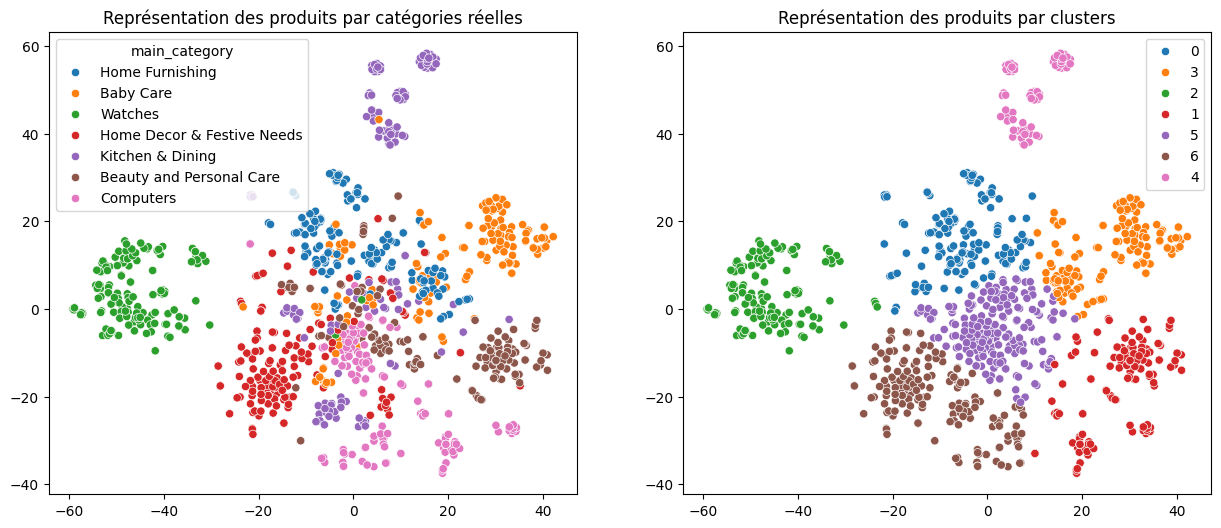

ARI :  0.422


In [11]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
TSNE_visu_fct(X_tsne, nums_labels, labels, ARI)

<h2 id='23'>2.3 Classification non-supervisée avec Tf-IDF</h2>

Tf-idf : 
--------
ARI :  0.506 time :  5.0


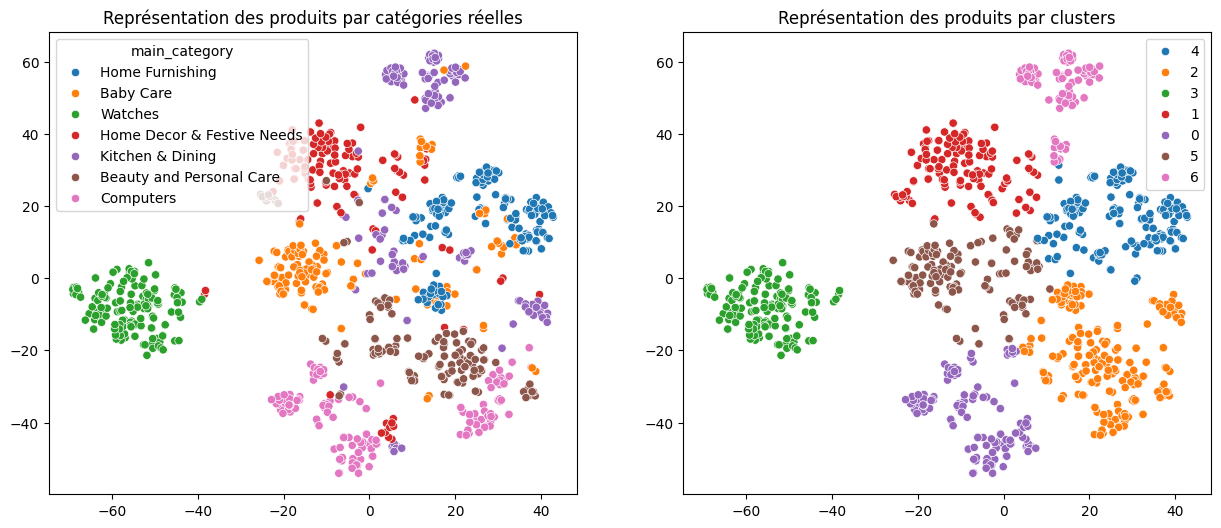

ARI :  0.506


In [12]:
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)
TSNE_visu_fct(X_tsne, nums_labels, labels, ARI)

Nous pouvons voir que les résultats de notre bag of words sont assez mitigés.

Certains catégories comme `watches`sont bien séparés des autres et présentent peu d'erreurs lors de la clusterisation.

D'autres catégories sont mélangés dans plusieurs clusters, car leurs descriptions ne sont pas assez dictinctes. Nous pouvons voir que le cluster 0 inclus des produits des catégories `computers` `Home decors` `Beauty and personnal care` and more

<h1 id='30'>Extraction des features avec des modèles d'embeddings</h1>

<h2 id='31'>3.1 Extraction des feeatures avec BERT</h2>

In [13]:
os.environ["TF_KERAS"]='1'

In [14]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = perf_counter()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(perf_counter() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [15]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = df['preprocessed_dl'].to_list()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [16]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 0s 419ms/step
temps traitement :  58.0


In [17]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.381 time :  6.0


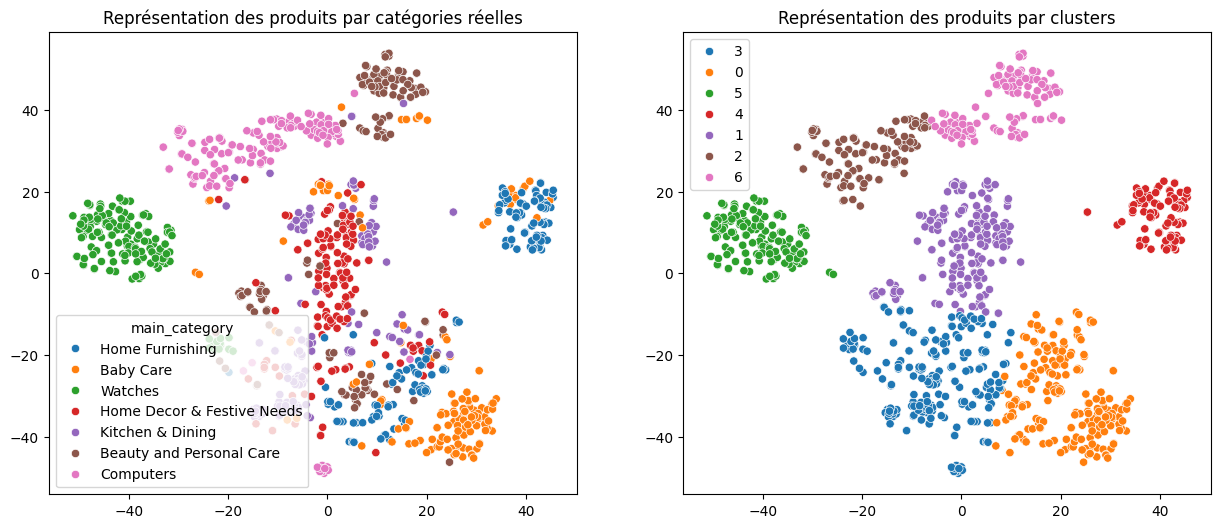

ARI :  0.381


In [18]:
TSNE_visu_fct(X_tsne, nums_labels, labels, ARI)

<h2 id='32'>3.2 Extraction des features avec USE (Universal Sentence Encoder)</h2>

In [19]:
os.environ["TF_KERAS"]='1'

In [25]:
import kagglehub

# Download latest version
path = kagglehub.model_download("google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder")

print("Path to model files:", path)


100%|██████████| 3.11k/3.11k [00:00<00:00, 1.59MB/s]








100%|██████████| 7.84M/7.84M [00:01<00:00, 5.87MB/s]
100%|██████████| 980M/980M [01:30<00:00, 11.4MB/s]

Path to model files: C:\Users\petit\.cache\kagglehub\models\google\universal-sentence-encoder\tensorFlow2\universal-sentence-encoder\2


In [26]:
embed = hub.load(path)#"https://tfhub.dev/google/universal-sentence-encoder/4")

In [27]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = perf_counter()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(perf_counter() - time1)
    return features

In [28]:
batch_size = 10
sentences = df['preprocessed_dl'].to_list()

In [29]:
features_USE = feature_USE_fct(sentences, batch_size)

ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.436 time :  6.0


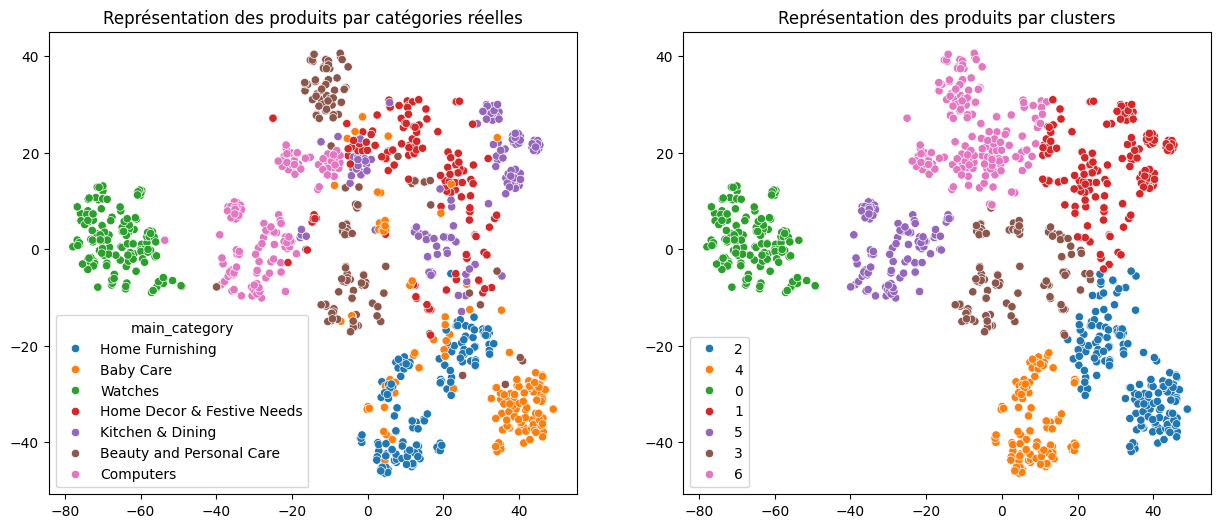

ARI :  0.436


In [30]:
TSNE_visu_fct(X_tsne, nums_labels, labels, ARI)

<h2 id='33'>3.3 Extraction des features avec Word2Vec</h2>

In [31]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 100 # adapt to length of sentences
sentences = [gensim.utils.simple_preprocess(text) for text in df["preprocessed_bow"]]

In [32]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4713
Word2Vec trained


In [33]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4714


In [34]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4714, 300)


In [35]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

c:\Users\petit\anaconda3\envs\flipkart\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 300)       │     1,414,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 300)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,414,200 (5.39 MB)

 Trainable params: 1,414,200 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step

c:\Users\petit\anaconda3\envs\flipkart\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1']. Received: the structure of inputs=*
  warnings.warn(


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


(1050, 300)

In [37]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.326 time :  8.0


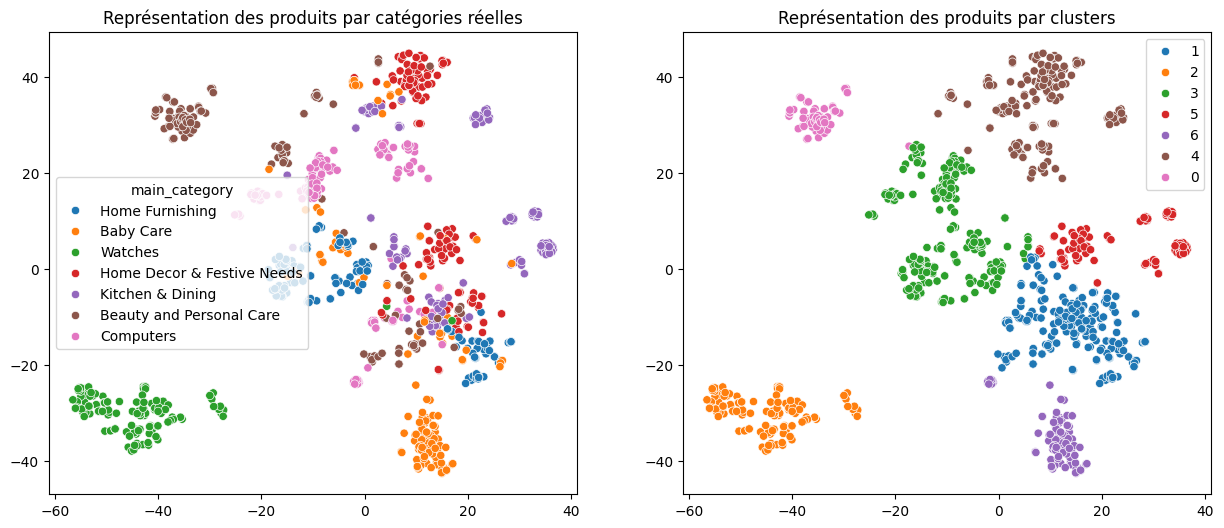

ARI :  0.326


In [38]:
TSNE_visu_fct(X_tsne, nums_labels, labels, ARI)

<h2 id='34'>3.4 Extraction des features avec FastText</h2>

In [39]:
import fasttext
from sklearn.model_selection import train_test_split

df_fast = df[['description', 'main_category']].copy()
df_fast['main_category'] = ["__label__" + text for text in df_fast['main_category']]

df_fast['category_description'] = df_fast['main_category'] + ' ' + df_fast["description"]

train, test = train_test_split(df_fast, test_size=0.2, stratify=df_fast['main_category'])


In [40]:
df_fast.head()

,description,main_category,category_description
0,Key Features of Elegance Polyester Multicolor ...,__label__Home Furnishing,__label__Home Furnishing Key Features of Elega...
1,Specifications of Sathiyas Cotton Bath Towel (...,__label__Baby Care,__label__Baby Care Specifications of Sathiyas ...
2,Key Features of Eurospa Cotton Terry Face Towe...,__label__Baby Care,__label__Baby Care Key Features of Eurospa Cot...
3,Key Features of SANTOSH ROYAL FASHION Cotton P...,__label__Home Furnishing,__label__Home Furnishing Key Features of SANTO...
4,Key Features of Jaipur Print Cotton Floral Kin...,__label__Home Furnishing,__label__Home Furnishing Key Features of Jaipu...


In [41]:
import csv
df_fast.to_csv('preprocessed_text.txt', columns=['category_description'], index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")
train.to_csv('ecommerce.train', columns=['category_description'], index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")
test.to_csv('ecommerce.test', columns=['category_description'], index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")

In [42]:
fasttxt_model = fasttext.train_supervised(input='ecommerce.train', epoch=25)

In [43]:
fasttxt_model.test('ecommerce.test')

(210, 0.9619047619047619, 0.9619047619047619)

In [44]:
test.head()

,description,main_category,category_description
483,Buy 4D Lenovo IdeaPad Y430g 6 Cell Laptop Batt...,__label__Computers,__label__Computers Buy 4D Lenovo IdeaPad Y430g...
806,Buy Mxofere Combo Papaya Mixfruit Almond Honey...,__label__Beauty and Personal Care,__label__Beauty and Personal Care Buy Mxofere ...
778,Buy Mxofere Combo Orange Papaya Jasmine Lemong...,__label__Beauty and Personal Care,__label__Beauty and Personal Care Buy Mxofere ...
544,"Only Kidz 20600 Digital Watch - For Boys, Gir...",__label__Watches,__label__Watches Only Kidz 20600 Digital Watch...
904,Key Features of Relaxfeel Floral Single Dohar ...,__label__Baby Care,__label__Baby Care Key Features of Relaxfeel F...


In [45]:
y_pred = []

for description in test['description']:
    pred = fasttxt_model.predict(description.replace('\n',''))
    pred_str = pred[0][0].replace('__label__','')
    
    y_pred.append(pred_str)

y_pred

['Computers',
 'Beauty',
 'Beauty',
 'Watches',
 'Home',
 'Home',
 'Home',
 'Kitchen',
 'Home',
 'Computers',
 'Computers',
 'Watches',
 'Home',
 'Home',
 'Kitchen',
 'Home',
 'Beauty',
 'Kitchen',
 'Home',
 'Computers',
 'Baby',
 'Computers',
 'Home',
 'Watches',
 'Watches',
 'Computers',
 'Baby',
 'Home',
 'Baby',
 'Home',
 'Home',
 'Kitchen',
 'Kitchen',
 'Watches',
 'Home',
 'Home',
 'Watches',
 'Home',
 'Home',
 'Kitchen',
 'Home',
 'Beauty',
 'Beauty',
 'Computers',
 'Kitchen',
 'Home',
 'Beauty',
 'Home',
 'Computers',
 'Watches',
 'Home',
 'Computers',
 'Kitchen',
 'Home',
 'Home',
 'Home',
 'Watches',
 'Home',
 'Home',
 'Kitchen',
 'Beauty',
 'Watches',
 'Computers',
 'Home',
 'Home',
 'Kitchen',
 'Watches',
 'Baby',
 'Home',
 'Baby',
 'Beauty',
 'Watches',
 'Watches',
 'Home',
 'Kitchen',
 'Watches',
 'Home',
 'Home',
 'Beauty',
 'Computers',
 'Kitchen',
 'Kitchen',
 'Computers',
 'Computers',
 'Watches',
 'Home',
 'Baby',
 'Beauty',
 'Beauty',
 'Baby',
 'Baby',
 'Home',
 'Ho

In [46]:
ari_fast = round(adjusted_rand_score(y_pred, test['main_category']),2)
ari_fast

0.49

<h1 id=''>Conclusion</h1>

En se servant du titre et de la description, les modèles de types Bag of Words donnent de meilleurs résults que les modèles d'embedding. Le meilleur score est de 0,50 pour le Tf-IDF.

Toutefois, un meilleur score est obtenu avec les modèles d'embedding (en particulier USE) en n'utilisant que le titre des produits